In [42]:
import warnings
import pandas as pd
import arviz as az

import os, sys
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path: sys.path.append(dir1)
from libs.metrics import calculate_metrics, metrics_to_table, metrics_to_latex
from libs.pre_processing import generate_groups_data_flat, generate_groups_data_matrix
from libs.visual_analysis import visualize_fit, visualize_predict, traceplot, visualize_prior, plot_elbo, plot_gps_components, model_graph
from libs.model import HGPforecaster
import numpy as np
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
az.style.use('arviz-darkgrid')
warnings.filterwarnings('ignore')
import json

import theano
theano.config.compute_test_value='raise'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from itertools import cycle
pd.set_option('max_columns', 50)
plt.style.use('bmh')
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

In [3]:
# Read in the data
INPUT_DIR = '../benchmark/m5-data'
cal = pd.read_csv(f'{INPUT_DIR}/calendar.csv')
stv = pd.read_csv(f'{INPUT_DIR}/sales_train_validation.csv')
ss = pd.read_csv(f'{INPUT_DIR}/sample_submission.csv')
sellp = pd.read_csv(f'{INPUT_DIR}/sell_prices.csv')

We are given historic sales data in the `sales_train_validation` dataset.
- rows exist in this dataset for days d_1 to d_1913. We are given the department, category, state, and store id of the item.
- d_1914 - d_1941 represents the `validation` rows which we will predict in stage 1
- d_1942 - d_1969 represents the `evaluation` rows which we will predict for the final competition standings.

In [4]:
stv.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,...,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,4,2,3,0,1,2,0,0,0,1,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0,0,0,0,1,2,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,3,1,2,1,3,1,0,2,5,4,2,0,3,0,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,4,0,1,4,0,1,0,1,0,1,1,2,0,1,1,2,1,1,0,1,1,2,2,2,4


## Merging the data with real dates
- We are given a calendar with additional information about past and future dates.
- The calendar data can be merged with our days data
- From this we can find weekly and annual trends

In [5]:
# Calendar data looks like this (only showing columns we care about for now)
cal[['d','date','event_name_1','event_name_2',
     'event_type_1','event_type_2', 'snap_CA']].head()

,d,date,event_name_1,event_name_2,event_type_1,event_type_2,snap_CA
0,d_1,2011-01-29,NaN,NaN,NaN,NaN,0
1,d_2,2011-01-30,NaN,NaN,NaN,NaN,0
2,d_3,2011-01-31,NaN,NaN,NaN,NaN,0
3,d_4,2011-02-01,NaN,NaN,NaN,NaN,1
4,d_5,2011-02-02,NaN,NaN,NaN,NaN,1


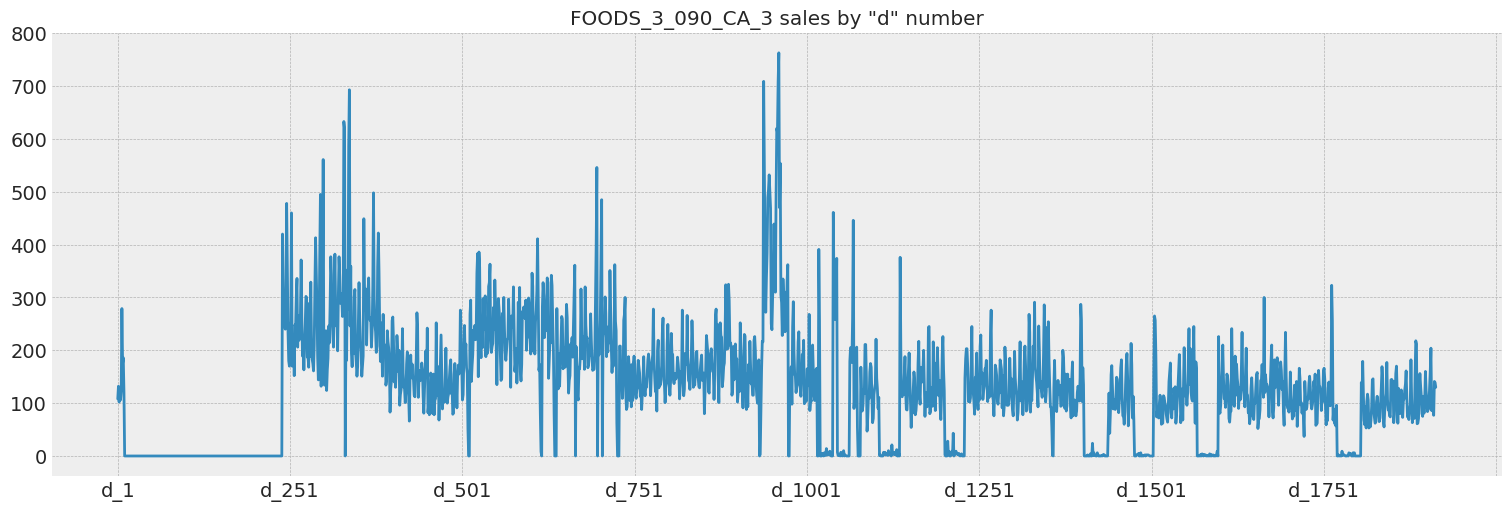

In [6]:
d_cols = [c for c in stv.columns if 'd_' in c] # sales data columns

# Below we are chaining the following steps in pandas:
# 1. Select the item.
# 2. Set the id as the index, Keep only sales data columns
# 3. Transform so it's a column
# 4. Plot the data
stv.loc[stv['id'] == 'FOODS_3_090_CA_3_validation'] \
    .set_index('id')[d_cols] \
    .T \
    .plot(figsize=(15, 5),
          title='FOODS_3_090_CA_3 sales by "d" number',
          color=next(color_cycle))
plt.legend('')
plt.show()

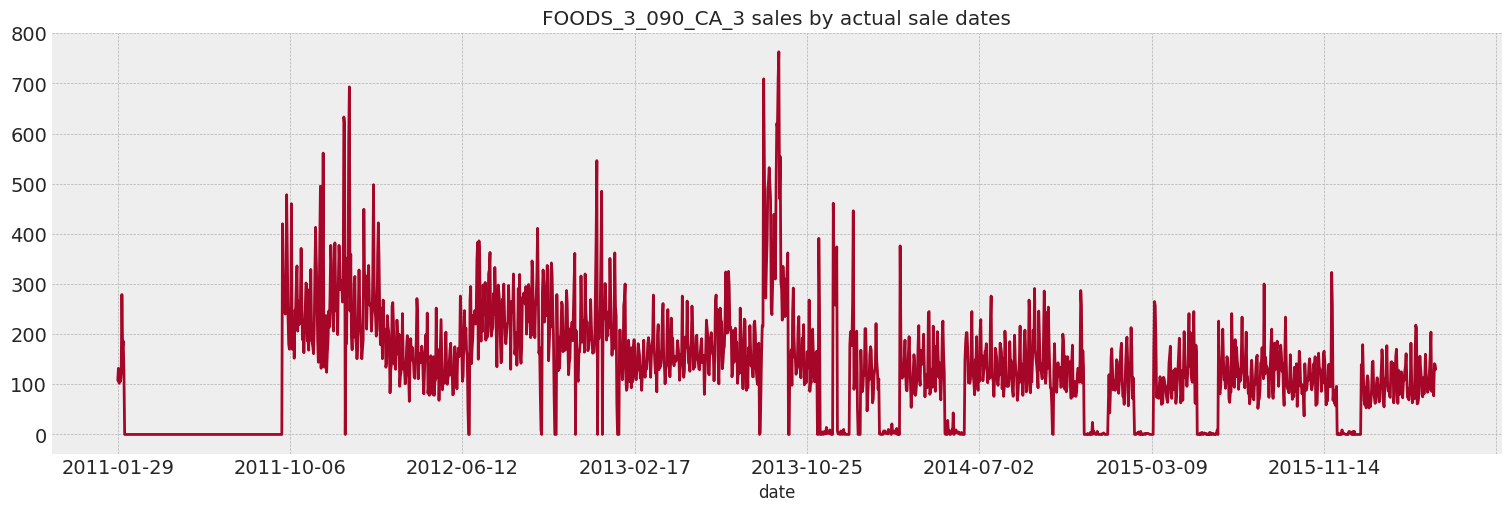

In [7]:
# Merge calendar on our items' data
example = stv.loc[stv['id'] == 'FOODS_3_090_CA_3_validation'][d_cols].T
example = example.rename(columns={8412:'FOODS_3_090_CA_3'}) # Name it correctly
example = example.reset_index().rename(columns={'index': 'd'}) # make the index "d"
example = example.merge(cal, how='left', validate='1:1')
example.set_index('date')['FOODS_3_090_CA_3'] \
    .plot(figsize=(15, 5),
          color=next(color_cycle),
          title='FOODS_3_090_CA_3 sales by actual sale dates')
plt.show()

In [8]:
stv.columns[:6]

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], dtype='object')

In [9]:
print(f'Number of unique items: {np.unique(stv.item_id).shape[0]}')
print(f'Number of unique department: {np.unique(stv.dept_id).shape[0]}')
print(f'Number of unique categories: {np.unique(stv.cat_id).shape[0]}')
print(f'Number of unique stores: {np.unique(stv.store_id).shape[0]}')
print(f'Number of unique states: {np.unique(stv.state_id).shape[0]}')

Number of unique items: 3049
Number of unique department: 7
Number of unique categories: 3
Number of unique stores: 10
Number of unique states: 3


In [10]:
# Transform column wide days to single column 

stv = stv.melt(list(stv.columns[:6]), var_name='day', value_vars=list(stv.columns[6:]), ignore_index=True)

In [11]:
# Group by the groups to consider (remove product_id as there are 3049 unique) 

stv = stv.groupby(['dept_id', 'cat_id', 'store_id', 'state_id', 'day']).sum('value').reset_index()

In [12]:
days_calendar = np.concatenate((stv['day'].unique().reshape(-1,1), cal['date'][:-56].unique().reshape(-1,1)), axis=1)
df_caldays = pd.DataFrame(days_calendar, columns = ['day','Date'])

In [13]:
# Add calendar days

stv = stv.merge(df_caldays, how='left', on='day')

In [14]:
stv['Date'] = stv['Date'].astype('datetime64[ns]')
stv.dtypes

dept_id             object
cat_id              object
store_id            object
state_id            object
day                 object
value                int64
Date        datetime64[ns]
dtype: object

In [15]:
# Transform in weekly data

stv_weekly = stv.groupby(['dept_id', 'cat_id', 'store_id', 'state_id']).resample('W', on='Date')['value'].sum()

In [16]:
stv_weekly

dept_id      cat_id     store_id  state_id  Date      
FOODS_1      FOODS      CA_1      CA        2011-01-30     473
                                            2011-02-06    2014
                                            2011-02-13    1755
                                            2011-02-20    1599
                                            2011-02-27    1589
                                                          ... 
HOUSEHOLD_2  HOUSEHOLD  WI_3      WI        2016-03-27     620
                                            2016-04-03     669
                                            2016-04-10     549
                                            2016-04-17     684
                                            2016-04-24     573
Name: value, Length: 19180, dtype: int64

In [17]:
# Build the structure to then apply the grouping transformation

stv_pivot = stv_weekly.reset_index().pivot(index='Date',columns=['dept_id', 'cat_id', 'store_id', 'state_id'], values='value')
stv_pivot = stv_pivot.fillna(0)

In [18]:
stv_pivot

dept_id    FOODS_1                                                        \
cat_id       FOODS                                                         
store_id      CA_1  CA_2  CA_3  CA_4  TX_1  TX_2  TX_3  WI_1  WI_2  WI_3   
state_id        CA    CA    CA    CA    TX    TX    TX    WI    WI    WI   
Date                                                                       
2011-01-30     473   678   631   179   247   386   235   509   343   248   
2011-02-06    2014  2710  2774  1272  1305  1823  1590  1751  1528  1239   
2011-02-13    1755  2737  2561  1259  1399  1933  1663  1503  1812  1195   
2011-02-20    1599  2339  2067  1186  1209  1680  1589  1493  2235  1211   
2011-02-27    1589  2370  2183  1145  1206  1705  1504  1515  1898  1224   
...            ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
2016-03-27    1868  2922  2380  1309  1307  1494  1252  1612  1639  1088   
2016-04-03    2001  2839  2352  1376  1338  1771  1392  1710  1903  1386   
2016-04-10    2022  2968  2700  1335  1362  1919  1521  1678  2241  1592   
2016-04-17    2441  2693  2600  1294  1481  1835  1411  1824  2370  1510   
2016-04-24    1872  2778  2226  1324  1216  1738  1492  1888  1642  1376   

dept_id    FOODS_2                                                       \
cat_id       FOODS                                                        
store_id      CA_1 CA_2  CA_3  CA_4  TX_1  TX_2  TX_3  WI_1  WI_2  WI_3   
state_id        CA   CA    CA    CA    TX    TX    TX    WI    WI    WI   
Date                                                                      
2011-01-30    1233  371  1419   628   711   947   837   162   372  1098   
2011-02-06    2699  812  3516  1567  1809  2381  2190  1916  2499  1720   
2011-02-13    3426  776  4313  1844  2025  2687  2588  2134  3464  2574   
2011-02-20    3509  773  4624  1868  2174  2632  2902  2689  5572  2694   
2011-02-27    3056  842  3993  1768  2278  2623  2613  2181  4584  2734   
...            ...  ...   ...   ...   ...   ...   ...   ...   ...   ...   
2016-03-27    2551  813  3684  1615  1715  2451  2034  1893  2856  1959   
2016-04-03    2262  893  3884  1793  2739  2696  2636  1901  3413  2235   
2016-04-10    3348  763  4502  1705  2282  2813  2758  2256  4792  2479   
2016-04-17    2889  794  4021  1678  2452  3121  2950  2193  4541  2825   
2016-04-24    2672  699  3718  1592  2006  2673  2172  1979  3005  1696   

dept_id    FOODS_3                             ... HOBBIES_2                 \
cat_id       FOODS                             ...   HOBBIES                  
store_id      CA_1   CA_2   CA_3  CA_4   TX_1  ...      TX_2 TX_3 WI_1 WI_2   
state_id        CA     CA     CA    CA     TX  ...        TX   TX   WI   WI   
Date                                           ...                            
2011-01-30    3979   2499   5114  1534   2402  ...        38   19   30   12   
2011-02-06   15023   9091  20551  7705  10012  ...       356  370  218  236   
2011-02-13   15701   9134  23482  8002  10646  ...       319  170  142  150   
2011-02-20   16412   9022  25455  7882  11037  ...       134  271  106  110   
2011-02-27   14118   8358  20154  7127  10530  ...       297  219  175  153   
...            ...    ...    ...   ...    ...  ...       ...  ...  ...  ...   
2016-03-27   14776   8597  20869  7630  10423  ...       246  182  144   96   
2016-04-03   17619   9237  20535  8200  10482  ...       318  188  123  153   
2016-04-10   18485  10008  26655  8999  11982  ...       315  191  180  169   
2016-04-17   15744   9444  22670  7910  12189  ...       293  250  188  137   
2016-04-24   15724   9528  21637  8388  10228  ...       400  231  240  182   

dept_id         HOUSEHOLD_1                                                   \
cat_id            HOUSEHOLD                                                    
store_id   WI_3        CA_1  CA_2   CA_3  CA_4  TX_1  TX_2  TX_3  WI_1  WI_2   
state_id     WI          CA    CA     CA    CA    TX    TX    TX    WI    WI 

In [19]:
groups_input = {
    'Department': [0],
    'Category': [1],
    'Store': [2],
    'State': [3]
}

In [20]:
# The dataset results from the removal of item_id (groupby by the ohter groups) and by downsampling to weekly data (the dataset was daily)

groups = generate_groups_data_flat(stv_pivot, groups_input, seasonality=52, h=12)

Number of groups: 4
	Department: 7
	Category: 3
	Store: 10
	State: 3
Total number of series: 70
Number of points per series for train: 262
Total number of points: 274
Seasonality: 52
Forecast horizon: 12


In [21]:
groups['predict']['data'] = groups['predict']['data'].reshape(groups['predict']['s'], groups['predict']['n']).T

In [22]:
df = pd.read_csv('/home/mach1ne/hierarchical_ts_forecaster/benchmark/forecasts_r_m5.csv', index_col=False, sep = ";")

In [23]:
total_df = df

In [24]:
import matplotlib.pyplot as plt
import numpy as np

In [25]:
n = len(np.unique(stv_pivot.index))

In [26]:
df['date'] = np.tile(np.unique(stv_pivot.index)[n-12:n], int(df.shape[0]/12))

In [27]:
total_df['.mean'] = total_df['.mean'].str.replace(',','.')

In [28]:
total_df.date = pd.to_datetime(total_df.date)

In [29]:
total_df = total_df.astype({'.mean': 'float32'})

In [30]:
total_df

,Category,State,Department,Store,.model,YearWeek,Count,.mean,date
0,FOODS,CA,FOODS_1,CA_1,base,2016 W05,"N(2746, 2e+05)",2746.012695,2016-02-07
1,FOODS,CA,FOODS_1,CA_1,base,2016 W06,"N(2746, 251270)",2746.012695,2016-02-14
2,FOODS,CA,FOODS_1,CA_1,base,2016 W07,"N(2746, 306656)",2746.012695,2016-02-21
3,FOODS,CA,FOODS_1,CA_1,base,2016 W08,"N(2746, 362436)",2746.012695,2016-02-28
4,FOODS,CA,FOODS_1,CA_1,base,2016 W09,"N(2746, 418613)",2746.012695,2016-03-06
...,...,...,...,...,...,...,...,...,...
5539,<aggregated>,<aggregated>,<aggregated>,<aggregated>,MinT,2016 W12,"N(252149, 7e+08)",252149.390625,2016-03-27
5540,<aggregated>,<aggregated>,<aggregated>,<aggregated>,MinT,2016 W13,"N(252289, 7.4e+08)",252288.671875,2016-04-03
5541,<aggregated>,<aggregated>,<aggregated>,<aggregated>,MinT,2016 W14,"N(252428, 7.8e+08)",252427.812500,2016-04-10
5542,<aggregated>,<aggregated>,<aggregated>,<aggregated>,MinT,2016 W15,"N(252567, 8.2e+08)",252566.875000,2016-04-17


In [31]:
total_df_mint = total_df[(total_df['.model']=='MinT')&(total_df['Category']!='<aggregated>')&(total_df['State']!='<aggregated>')&(total_df['Department']!='<aggregated>')&(total_df['Store']!='<aggregated>')]

In [32]:
res_mint = total_df_mint.pivot(index='date',columns=['Department', 'Category', 'Store', 'State'], values='.mean')

In [33]:
res_mint = res_mint.sort_index(axis=1,level=[0,1, 2, 3],ascending=[True,True, True, True])

In [34]:
res_mint

Department      FOODS_1                                                      \
Category          FOODS                                                       
Store              CA_1         CA_2         CA_3         CA_4         TX_1   
State                CA           CA           CA           CA           TX   
date                                                                          
2016-02-07  2703.097656  3192.330078  3030.025391  1315.774780  1290.680420   
2016-02-14  2703.465820  3192.835449  3030.481689  1315.945312  1291.364990   
2016-02-21  2703.819336  3193.339600  3030.923584  1316.109619  1292.046143   
2016-02-28  2704.160645  3193.842529  3031.353516  1316.268677  1292.724365   
2016-03-06  2704.491699  3194.344238  3031.772949  1316.423340  1293.399902   
2016-03-13  2704.814209  3194.844971  3032.183350  1316.574219  1294.072998   
2016-03-20  2705.129395  3195.344727  3032.585938  1316.722046  1294.744141   
2016-03-27  2705.438965  3195.843506  3032.981934  1316.867310  1295.413330   
2016-04-03  2705.743408  3196.341553  3033.372070  1317.010376  1296.080811   
2016-04-10  2706.043457  3196.838867  3033.757080  1317.151611  1296.746948   
2016-04-17  2706.340332  3197.335449  3034.137939  1317.291138  1297.411621   
2016-04-24  2706.634033  3197.831299  3034.514893  1317.429443  1298.075195   

Department                                                                   \
Category                                                                      
Store              TX_2         TX_3         WI_1         WI_2         WI_3   
State                TX           TX           WI           WI           WI   
date                                                                          
2016-02-07  2102.612061  1392.213745  1945.394165  2014.188721  1142.668945   
2016-02-14  2103.255615  1392.693115  1945.955322  2015.000610  1142.908325   
2016-02-21  2103.889404  1393.163574  1946.513306  2015.811035  1143.144165   
2016-02-28  2104.515137  1393.626343  1947.068726  2016.620483  1143.376831   
2016-03-06  2105.134521  1394.083008  1947.621948  2017.428833  1143.606812   
2016-03-13  2105.748291  1394.534546  1948.173462  2018.236572  1143.834473   
2016-03-20  2106.357666  1394.981689  1948.723389  2019.043579  1144.060303   
2016-03-27  2106.963379  1395.425415  1949.271973  2019.850098  1144.284424   
2016-04-03  2107.565674  1395.866089  1949.819580  2020.656250  1144.507202   
2016-04-10  2108.165527  1396.304199  1950.366211  2021.462036  1144.728638   
2016-04-17  2108.763184  1396.740356  1950.912109  2022.267578  1144.949219   
2016-04-24  2109.359131  1397.174805  1951.457397  2023.072754  1145.168701   

Department      FOODS_2                                                     \
Category          FOODS                                                      
Store              CA_1        CA_2         CA_3         CA_4         TX_1   
State                CA          CA           CA           CA           TX   
date                                                                         
2016-02-07  3100.698242  932.722717  4131.029297  1864.175049  2072.629150   
2016-02-14  3101.960205  933.501160  4132.760742  1865.033813  2072.872559   
2016-02-21  3103.214111  934.286804  4134.479492  1865.889893  2073.183350   
2016-02-28  3104.461670  935.078125  4136.188477  1866.743774  2073.554199   
2016-03-06  3105.703369  935.874023  4137.888672  1867.595825  2073.978760   
2016-03-13  3106.940674  936.673523  4139.581543  1868.446167  2074.451660   
2016-03-20  3108.173828  937.475891  4141.267578  1869.295166  2074.967773   
2016-03-27  3109.403809  938.280579  4142.947754  1870.143066  2075.522705   
2016-04-03  3110.630859  939.086975  4144.623047  1870.989746  2076.112061   
2016-04-10  3111.855469  939.894836  4146.294434  1871.835693  2076.732422   
2016-04-17  3113.078125  940.703857  4147.961914  1872.680786  2077.380615   
2016-04-24  3114.299072  941.513733  4149.625977  1873.525269  2

In [35]:
res_mint = res_mint.values

In [103]:
s = 70
h = 12

In [37]:
res = np.tile(res_mint.T.reshape(s,h,1), 10)

In [38]:
res = res.transpose(0, 2, 1)

In [39]:
res = np.concatenate((np.zeros((s, 10, n-h), dtype=np.float64), res), axis=2)
res = np.transpose(res, (1, 2, 0))

In [40]:
res.shape

(10, 274, 70)

In [106]:
groups = generate_groups_data_flat(y = stv_pivot, 
                               groups_input = groups_input, 
                               seasonality=52, 
                               h=12)
groups = generate_groups_data_matrix(groups)

Number of groups: 4
	Department: 7
	Category: 3
	Store: 10
	State: 3
Total number of series: 70
Number of points per series for train: 262
Total number of points: 274
Seasonality: 52
Forecast horizon: 12


In [107]:
from sklearn.metrics import mean_squared_error

results = calculate_metrics(res, groups)
metrics_to_table(results)

,bottom,total,Department,Category,Store,State,all
mase,0.45,0.382,0.399,0.395,0.42,0.406,0.446
rmse,443.511,16665.489,3507.043,6879.751,2034.319,6064.473,1524.977


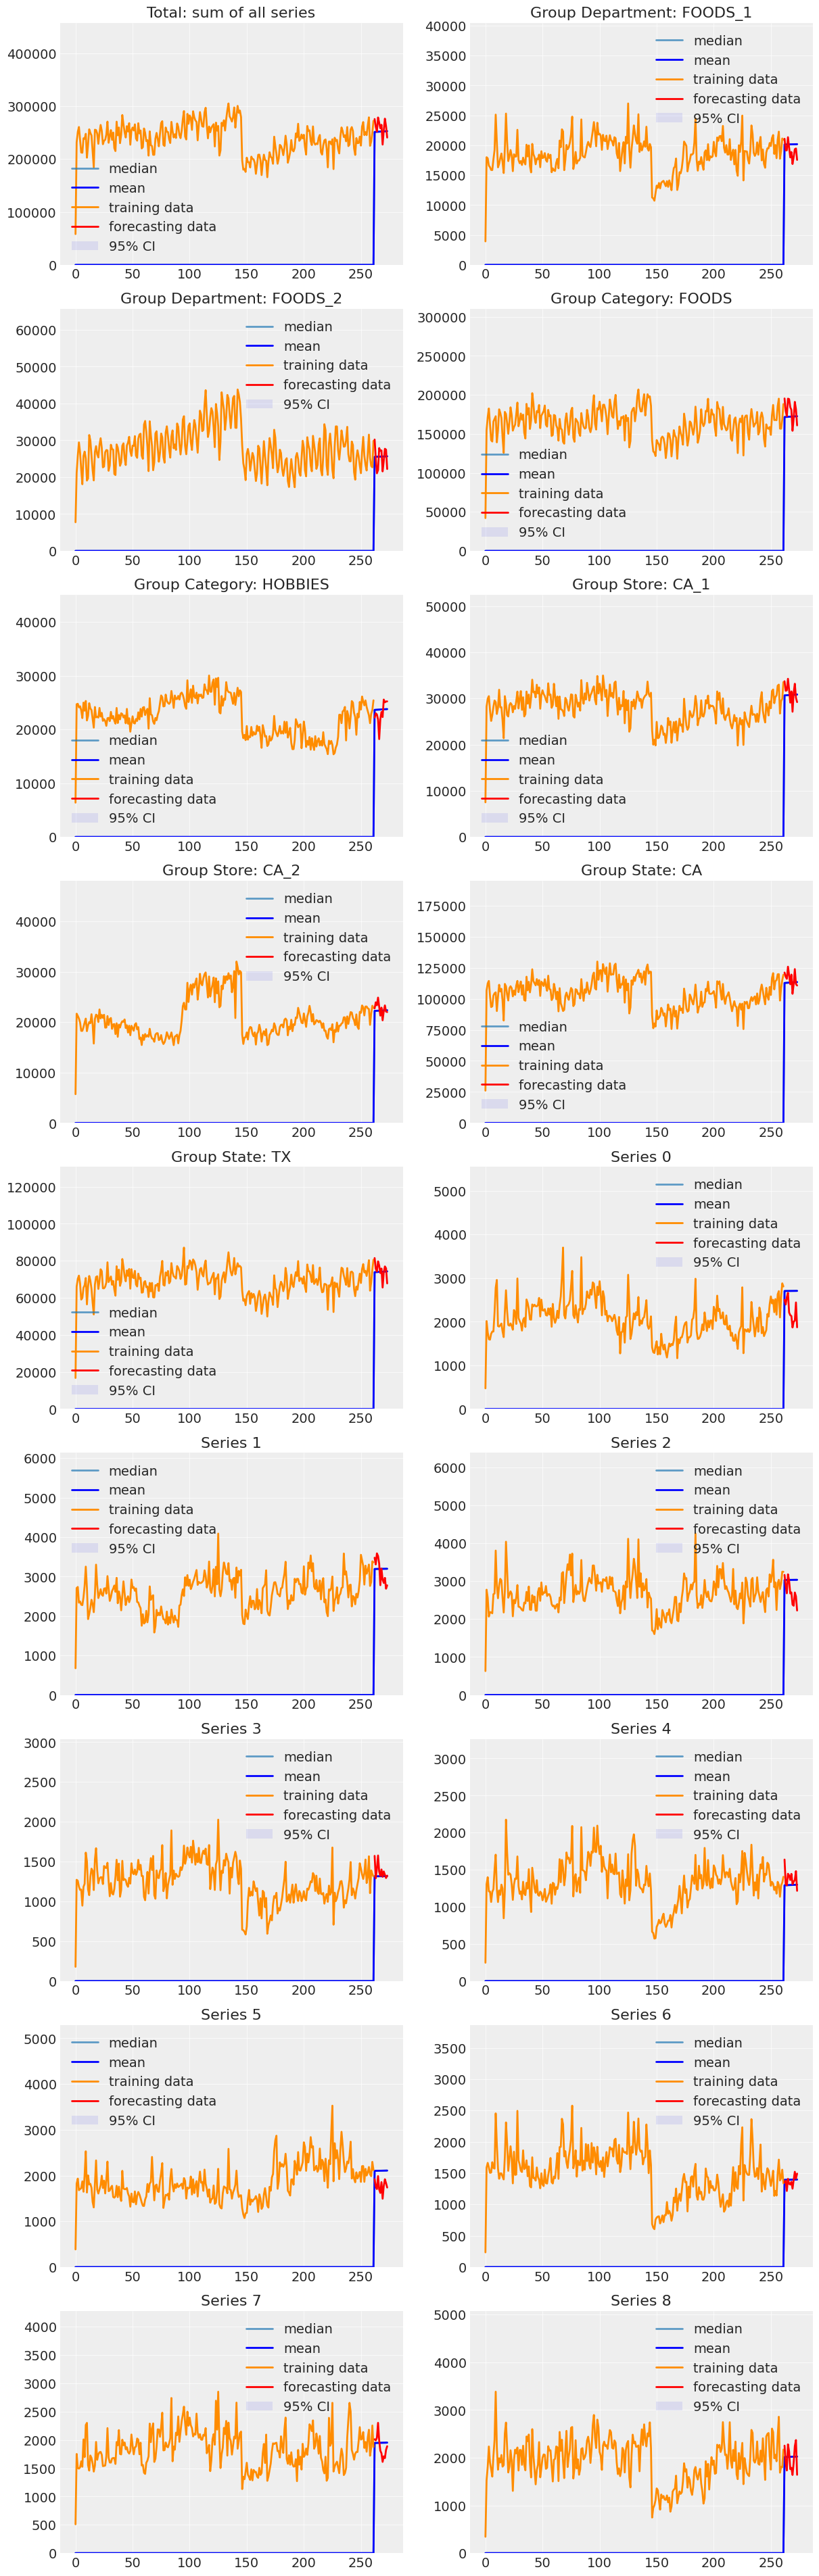

In [108]:
visualize_predict(groups, res, 10)

### Base and bottom-up forecasting

##### Base

In [109]:
def mase(n,seas,h,y,f):
    return np.mean(((n-seas)/h
            * (np.sum(np.abs(y[n:n+h,:] - f), axis=0)
               / np.sum(np.abs(y[seas:n, :] - y[:n-seas, :]), axis=0))))


In [110]:
total_df_mint = total_df[(total_df['.model']=='base')]
res_mint = total_df_mint.pivot(index='date',columns=['Department', 'Category', 'Store', 'State'], values='.mean')
res_mint = res_mint.sort_index(axis=1,level=[0,1, 2, 3],ascending=[True,True, True, True])

In [111]:
filters = []
filters.append(['<aggregated>', '<aggregated>', '<aggregated>', '<aggregated>'])
for i in list(groups['train']['groups_names'].keys()):
    for j in groups['train']['groups_names'][i]:
        list_init = ['<aggregated>', '<aggregated>', '<aggregated>', '<aggregated>']
        list_init[list(groups['train']['groups_names'].keys()).index(i)] = j
        filters.append(list_init)

In [112]:
df = pd.DataFrame(columns=['Department', 'Category', 'Store', 'State','.model', 'Count', '.mean', 'YearWeek', 'date'])
for i in filters:
    df = df.append(total_df[(total_df['.model']=='base')&(total_df['Department']==i[0])&((total_df['Category']==i[1])|(total_df['Category']==i[0][:-2]))&(total_df['Store']==i[2])&((total_df['State']==i[3])|(total_df['State']==i[2][:-2]))])

In [113]:
df = df.reset_index().drop('index', axis=1)

In [114]:
h = groups['h']
seasonality = groups['seasonality']

In [135]:
idx_dict_new = {}
s = groups['predict']['s']
n = groups['predict']['n']
y_f = groups['predict']['data'].reshape(s, n).T
mase_ = {}
groups_hier = {'Category': 'Department', 'State': 'Store'}

for group in list(groups['predict']['groups_names'].keys()):
    y_g = np.zeros((groups['predict']['n'], groups['predict']['groups_names'][group].shape[0]))
    f_g = np.zeros((h, groups['predict']['groups_names'][group].shape[0]))

    for idx, name in enumerate(groups['predict']['groups_names'][group]):  
        g_n = groups['predict']['groups_n'][group]

        idx_dict_new[name] = np.where(groups['predict']['groups_idx'][group]==idx,1,0)
        y_g[:,idx] = np.sum(idx_dict_new[name]*y_f, axis=1)
        if group.capitalize()=='Category' or group.capitalize()=='State':
            # if it is one of the top level hierarchies, all the others must be <aggregate>
            f_g[:,idx] = np.squeeze(df[(df[group.capitalize()]==name)&(df[groups_hier[group.capitalize()]]=='<aggregated>')][['.mean']].values)
        else:
            f_g[:,idx] = np.squeeze(df[(df[group.capitalize()]==name)][['.mean']].values)

    mase_[group] = np.round(mase(n=n-h, 
         seas=seasonality, 
         h=h, 
         y=y_g, 
         f=f_g)
    ,3)

In [137]:
mase_

{'Department': 0.394, 'Category': 0.393, 'Store': 0.4, 'State': 0.39}

In [139]:
total_df_mint = total_df[(total_df['.model']=='base')&(total_df['Category']=='<aggregated>')&(total_df['State']=='<aggregated>')&(total_df['Department']=='<aggregated>')&(total_df['Store']=='<aggregated>')]
res_mint = total_df_mint.pivot(index='YearWeek',columns=['Department', 'Category', 'Store', 'State'], values='.mean')
res_mint = res_mint.sort_index(axis=1,level=[0,1, 2, 3],ascending=[True,True, True, True])
res_mint = res_mint.values
f_g = res_mint

In [140]:
y_g = np.sum(groups['predict']['data'].reshape(groups['predict']['s'], groups['predict']['n']).T, axis=1)

In [141]:
mase_total = np.round(mase(n=n-h, 
         seas=seasonality, 
         h=h, 
         y=y_g.reshape(-1,1), 
         f=f_g)
    ,3)
mase_total

0.353

##### Bottom-up

In [144]:
total_df_mint = total_df[(total_df['.model']=='bottom_up')&(total_df['Category']!='<aggregated>')&(total_df['State']!='<aggregated>')&(total_df['Department']!='<aggregated>')&(total_df['Store']!='<aggregated>')]
res_mint = total_df_mint.pivot(index='YearWeek',columns=['Department', 'Category', 'Store', 'State'], values='.mean')
res_mint = res_mint.sort_index(axis=1,level=[0,1,2, 3],ascending=[True,True, True, True])
res_mint = res_mint.values
res = np.tile(res_mint.T.reshape(s,h,1), 10)
res = res.transpose(0, 2, 1)
res = np.concatenate((np.zeros((s, 10, n-h), dtype=np.float64), res), axis=2)
res = np.transpose(res, (1, 2, 0))

results = calculate_metrics(res, groups)
metrics_to_table(results)

,bottom,total,Department,Category,Store,State,all
mase,0.452,0.346,0.395,0.385,0.395,0.383,0.445
rmse,435.776,15466.2,3402.439,6527.554,1946.65,5731.372,1437.804
